<a href="https://colab.research.google.com/github/apmoore1/fiesta/blob/master/notebooks/Advantages_of_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/apmoore1/fiesta.git@master#egg=fiesta-nlp
!pip install seaborn
!pip install pandas

In [0]:
from typing import Dict, List, Callable, Tuple, Any
from itertools import product
import random

import fiesta
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
import numpy as np
import requests

In [0]:
def get_data() -> Dict[str, float]:
  '''
  :returns: The F1 scores for each of the TDSA models, where the key of the 
            dictionary are the model names and the values their 500 F1 scores 
            that have come from different random seeds and data splits.
  '''
  data_url = 'https://raw.githubusercontent.com/apmoore1/fiesta/master/'\
             'results/TDSA/test_f1.json'
  return requests.get(data_url).json()

def seaborn_violin_plot(tdsa_data: Dict[str, float]) -> None:
  '''
  Converts the tdsa_data into long format and puts it into a 
  DataFrame where the `Model` column contains the model name and the 
  `Macro F1` column contains a single Macro F1 score for that Model.
  Then using this DataFrame plots a violin plot.
            
  :param tdsa_data: The data that is returned from `get_data` function
  '''
  # Load the data into a DataFrame in long format
  model_names = []
  all_f1_scores = []
  for model_name, model_f1_scores in tdsa_data.items():
    model_name = model_name.upper()
    if '_' in model_name:
      split_name = model_name.split('_')
      model_name = 'D\n'.join([split_name[1], split_name[0]])
    else:
      model_name = f'300D\n{model_name}'
    for f1_score in model_f1_scores:
      model_names.append(model_name)
      all_f1_scores.append(f1_score)
  tdsa_sns_df = pd.DataFrame({'Model': model_names, 
                              'Macro F1': all_f1_scores})
  
  # Get the plotting order so that they are in the following model order and 
  # 300 dimension Glove models come before the 50 dimension Glove models
  model_names = ['TDLSTM', 'IAN', 'ATAE', 'LSTM']
  dims = ['300D\n', '50D\n']
  plot_order = product(dims, model_names)
  plot_order = [f'{dim}{model_name}' for dim, model_name in plot_order]
  
  # Plot the data in a violin plot
  sns.violinplot(x='Model', y='Macro F1', data=tdsa_sns_df, inner="quartiles",
                 order=plot_order)

In [0]:
def model_generator(model_scores: List[float]
                    ) -> Callable[[List[Dict[str, Any]], List[Dict[str, Any]]], 
                                  float]:
  '''
  :param model_scores: A list of model scores from difference model evaluations
  :returns: A function that accepts dummy Tuple of List data and returns a 
            randomly chosen score from the list of model scores given as an 
            argument
  '''
  def _model_function(dummy_data_1: List[Dict[str, Any]],
                      dummy_data_2: List[Dict[str, Any]]) -> float:
    return random.choice(model_scores)
  return _model_function

def dummy_split_function(data: List[Dict[str, Any]]
                         ) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
  return ([{'nothing': 1}], [{'nothing': 3}])

def fb_probability_plot(func_budget_correct: Dict[str, Dict[int, float]]
                        ) -> None:
  '''
  Given a dictionary that contains 
  {`function name`: {`budget value`: `probability correct`}}
  it will plot the budget on the X axis, the probability that the Fixed budget 
  function will find the best model with that budget on the Y axis, and the 
  colour will denote the Fixed Budget function used.
  '''
  fb_func_names: List[str] = []
  budgets: List[int] = []
  correct_probabilities: List[float] = []
  for fb_func_name, budget_correct in func_budget_correct.items():
    for budget, correct_probability in budget_correct.items():
      fb_func_names.append(fb_func_name)
      budgets.append(budget)
      correct_probabilities.append(correct_probability)
  
  fb_prop_data = {'Budget': budgets, 'FB function names': fb_func_names,
                  'Probability of selecting optimal': correct_probabilities}
  fb_prop_data = pd.DataFrame(fb_prop_data)
  fig, ax = pyplot.subplots(figsize=(10, 7.5))
  g = sns.barplot(x="Budget", y="Probability of selecting optimal", 
                  hue='FB function names', data=fb_prop_data, ci=None,
                  estimator=np.sum, ax=ax)
  g.set(ylim=(0.6, None))

# The advantages of better model selection algorthims.

In this notebook we will show you the speed benenfit with regards to the number of model evlautions required to find the best model given either a fixed budget of **T** evaluation or confidence level e.g. p value of 0.05.

Currently the way the majority of NLP papers would tackle the problem of model evaluation is by running each model **K** times until they find a model that is better than the rest given some p value e.g. 0.05. This type of method we call *non adaptive* as it evlautes all models equally and even when you know after 2, 3, 4,  etc evluations some models are more likely to be the best model.

Instead we will show in this notebook that by treating model evaluation as a multi arm bandit problem, where each arm represents a different model to evaluate we can find the best model in fewer evaluations than the current *non adaptive* approaches. 

We break the problem of model evaluation into Fixed Budget (FB) and Fixed Confidence (FC) where each has a different constriant. FB constrains on the number of evaluations that can be made where an evaluation is a model running once producing a metric score e.g. Accuracy. FC constrains on finding the best model with a p value less than *p*. In both cases we will show that our *adaptive* multi arm bandit approachs outperform with regards to the number of model evlautions than the standard *no adaptive approaches*. We will show the affectivness of our approach on the Target Dependent Sentiment Analsysis (TDSA) task.



The notebook is broken down into the following sections:
1. Outline of the TDSA task, models, the results already pre-computed
2. Fixed Constriant problem
3. Fixed Budget problem

## Outline of the TDSA task
Target Dependent Sentiment Anlysis is the task of predict the sentiment of a target within a sentence. The main difference between this and document/sentence level sentiment analysis is that within a sentence there can be multiple targets with different sentiments e.g.

`The laptop was great but the battery life was awful`

Within this example sentence the target `laptop` would be positive where as the target `battery life` would be negative.

### Data

We used the well known [SemEval 2014 task 4 Restaurant dataset](https://aclweb.org/anthology/papers/S/S14/S14-2004/)

### Models

We use 4 different model archtectures of which each but the last were state of the art at the time they were published:
1. [ATAE](https://www.aclweb.org/anthology/D16-1058) (Target word embedding concat onto each words embedding and then put through a LSTM and then attention)
2. [IAN](https://www.ijcai.org/proceedings/2017/0568.pdf) (Interactive Attention Network)
3. [TDLSTM](https://aclweb.org/anthology/papers/C/C16/C16-1311/) (Two LSTMs one going forward from the left most word upto the the target and another going backward from the right most word to the target word)
4. LSTM (baseline standard LSTM over the sentence text without taking the target into account)

We then created 8 different models from these 4 by using two different word embeddings 
1. [Glove](https://nlp.stanford.edu/projects/glove/) 300D 840B token 
2. [Glove](https://nlp.stanford.edu/projects/glove/) 50D 6B token.

### Results

We have evaluated each of these 8 models 500 times using a 100 different train, development, and test splits and a different random seed for each of these evaluations. The evaluation metric used was Macro F1 and the results from these evaluations can be seen below:

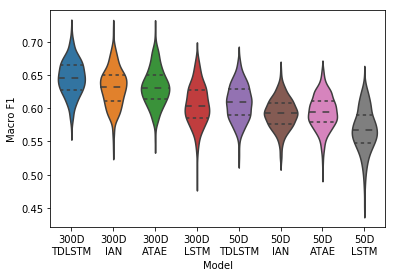

In [20]:
tdsa_f1_results = get_data()
seaborn_violin_plot(tdsa_f1_results)

As we can see the best model is the TDLSTM with 300 Dimension Glove vectors. However we can also see that IAN and ATAE are very close to the performance of the best model thus making it hard to find best model problem.

## FC
Here given these 8 models we want to find the best model with 95% confidence (p value 0.05). First we need to create model functions for each of the model's where these model function when called will randomly return an evaluation results (F1 score) from the models 500 evlautions.

In [21]:
model_names: List[str] = []
model_f1_scores: List[float] = []
for model_name, model_scores in tdsa_f1_results.items():
  model_names.append(model_name)
  model_f1_scores.append(model_scores)

# Model functions
model_functions = [model_generator(model_scores) 
                   for model_scores in model_f1_scores] 
print(f'Model Names: {", ".join(model_names)}')

Model Names: atae, atae_50, ian, ian_50, lstm, lstm_50, tdlstm, tdlstm_50


Now we will show how many evaluations it takes for the standard non-adaptive apporach to find the best model with 95% confidence:

In [22]:
confidence_scores, _, num_evals, _ = fiesta.non_adaptive_fc([], model_functions, 
                                                            dummy_split_function, 0.05)
# Best model
best_model_name = model_names[np.argmax(confidence_scores)]
print(f'Best model: {best_model_name}\nNumber of evaluations {num_evals}')

Best model: tdlstm
Number of evaluations 128


As we can see, it has found the best model TDLSTM but it has taken a lot of model evaluations to find the best (208). We will now show that by using our adaptive Top-Two Thompson Sampling approach we can do this with far fewer model evaluations.

In [23]:
confidence_scores, _, num_evals, _ = fiesta.TTTS([], model_functions, 
                                                 dummy_split_function, 0.05)
# Best model
best_model_name = model_names[np.argmax(confidence_scores)]
print(f'Best model: {best_model_name}\nNumber of evaluations {num_evals}')

Best model: tdlstm
Number of evaluations 61


As shown it found the best model and done it in 67 fewer model evlautions. In the paper we show that the mean number of model evaluations required is 61 using TTTS compared to 128 using the standard non adaptive approach.

Below shows the code on how we got general statistics from table 2 in the paper **(NOTE this will take a long time and probably should not be ran on Google Colab due to how long it will take to run.)**

In [0]:
# 10 -- Number of times to run the TTTS function (In the paper this is 500)
# 0.2 the P-Value that the best model is the best model
# 6 index of the best model (TDLSTM)
number_runs = 10
correct_model_index = 6
ttts_kwargs = {'data': [], 'model_functions': model_functions, 
               'split_function': dummy_split_function, 'p_value': 0.2}


TTTS_stats = fiesta.util.fc_func_stats(number_runs, correct_model_index, 
                                       'TTTS', **ttts_kwargs)
TTTS_min, TTTS_mean, TTTS_max, TTTS_correct = TTTS_stats

In [0]:
# 10 -- Number of times to run the standard non-adaptive function 
# (In the paper this is 500)
# 0.2 the P-Value that the best model is the best model
# 6 index of the best model (TDLSTM)

non_adaptive_kwargs = ttts_kwargs
standard_fc_stats = fiesta.util.fc_func_stats(number_runs, correct_model_index, 
                                              'non_adaptive_fc', 
                                              **non_adaptive_kwargs)
standard_min, standard_mean, standard_max, standard_correct = standard_fc_stats

In [26]:
TTTS_stats

(38, 64.6, 132, 10.0)

In [27]:
standard_fc_stats

(40, 135.2, 328, 10.0)

# FB
Here given these 8 models and a budget of **T** model evaluations we want to make the best use of the budget so that we are more likely to select the best model from the set of models. Using the same model functions and 500 model evaluations from the **FC** section we show that at different budget levels the probability we get the best model correct.

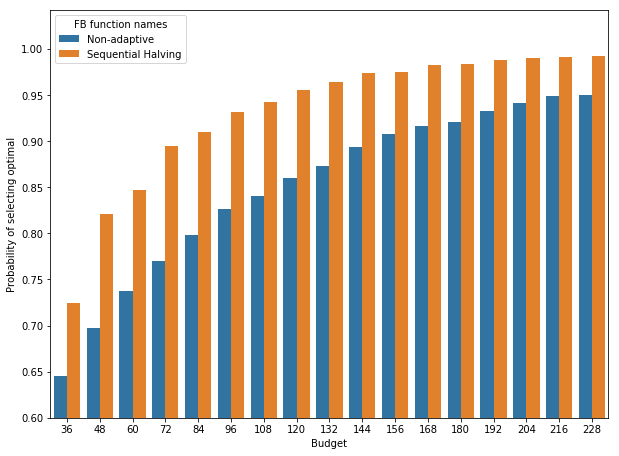

In [28]:
budgets = list(range(36, 229, 12)) # Increments of 12 from 36 to 228
number_runs = 10000
correct_model_index = 6

fb_func_pretty_names = ['Non-adaptive', 'Sequential Halving']
fb_func_names = ['non_adaptive_fb', 'sequential_halving']
fb_func_kwargs = {'data': [], 'split_function': dummy_split_function, 
                  'model_functions': model_functions}

fb_func_budget_probability_correct: Dict[str, Dict[int, float]] = {'Non-adaptive': {}, 
                                                                   'Sequential Halving': {}}

for budget in budgets:
  for fb_func_pretty_name, fb_func_name in zip(fb_func_pretty_names, fb_func_names):
    fb_func_kwargs['budget'] = budget
    probability_correct = fiesta.util.fb_func_stats(number_runs, correct_model_index, 
                                                    fb_func_name, **fb_func_kwargs)
    fb_func_budget_probability_correct[fb_func_pretty_name][budget] = probability_correct
fb_probability_plot(fb_func_budget_probability_correct)

As we can see above the adaptive sequential halving method is by far a lot better than the standard non adaptive approach. After 120 model evaluation which is the equivalent to 15 evaluations per model we have reached a probability of 0.9555 of selecting the best model where as it would take at least 228 model evaluation for the non adaptive to get this probability which is the equivalent of evaluating each model 28 times.

In [29]:
fb_func_budget_probability_correct['Sequential Halving'][120]

0.9555

In [30]:
fb_func_budget_probability_correct['Non-adaptive'][228]

0.9502